In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)

from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/plant-growth-data-classification/plant_growth_data.csv


# Introduction:

# We are trying to prodict the growth milestone (0 or 1) of a plant based on characteries such as temperature, water frequency and fertiliser.

In [2]:
path = "/kaggle/input/plant-growth-data-classification/plant_growth_data.csv"

plant_df = pd.read_csv(path)

target_col = 'Growth_Milestone'

target = plant_df[target_col]

plant_df.head()

,Soil_Type,Sunlight_Hours,Water_Frequency,Fertilizer_Type,Temperature,Humidity,Growth_Milestone
0,loam,5.192294,bi-weekly,chemical,31.719602,61.591861,0
1,sandy,4.033133,weekly,organic,28.919484,52.422276,1
2,loam,8.892769,bi-weekly,none,23.179059,44.660539,0
3,loam,8.241144,bi-weekly,none,18.465886,46.433227,0
4,sandy,8.374043,bi-weekly,organic,18.128741,63.625923,0


In [3]:
unique_values = plant_df['Growth_Milestone'].unique()
unique_values

array([0, 1])

# 1. Check for NAN Values

In [4]:
plant_df_row_mask= plant_df.isna().any(axis=1)
rows = plant_df[plant_df_row_mask]
for row in rows:
    print(f"Row{row} has {plant_df[row].isna().sum()} NaN values")

RowSoil_Type has 0 NaN values
RowSunlight_Hours has 0 NaN values
RowWater_Frequency has 0 NaN values
RowFertilizer_Type has 0 NaN values
RowTemperature has 0 NaN values
RowHumidity has 0 NaN values
RowGrowth_Milestone has 0 NaN values


# 2. Exploring the Data

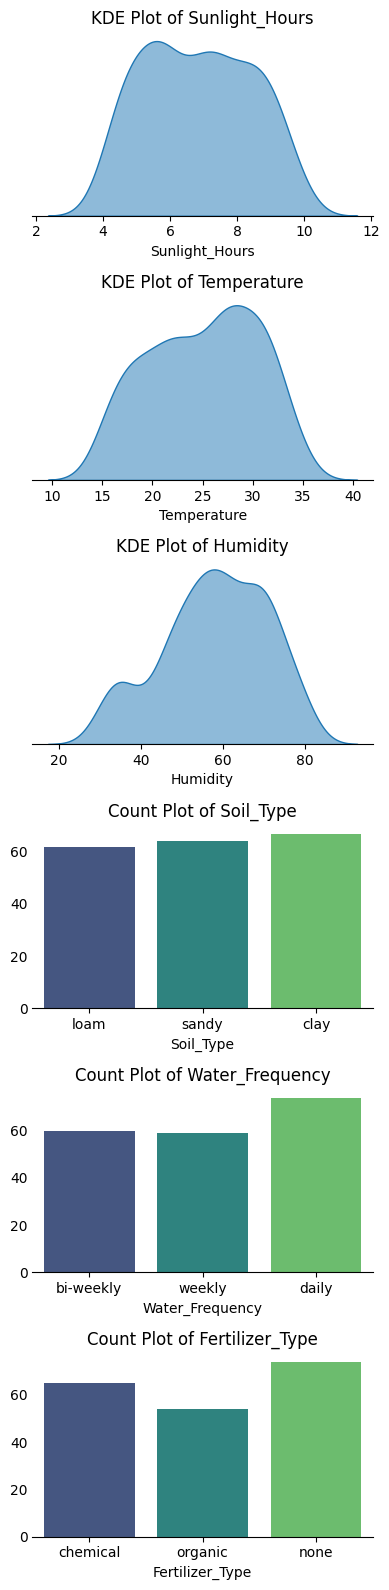

In [5]:
plant_df_dropped = plant_df.drop('Growth_Milestone', axis=1)
categorical_cols = plant_df_dropped.select_dtypes(include=['object', 'category']).columns
numerical_cols = plant_df_dropped.select_dtypes(include=['number']).columns

num_categorical = len(categorical_cols)
num_numerical = len(numerical_cols)

fig, axes = plt.subplots(nrows=num_categorical + num_numerical, ncols=1, figsize=(4,16))

for i, col in enumerate(numerical_cols):
        sns.kdeplot(data=plant_df, x=col, ax=axes[i], fill=True, alpha=.5)
        axes[i].set_title(f"KDE Plot of {col}")
        axes[i].set_yticklabels([])
        axes[i].set_ylabel("")
        axes[i].tick_params(axis="y", length=0)
        for direction in ["top", "right", "left"]:
            axes[i].spines[direction].set_visible(False)
            
for j, col in enumerate(categorical_cols):
        sns.countplot(data=plant_df, x=col, ax=axes[num_numerical + j], palette="viridis")
        axes[num_numerical + j].set_title(f"Count Plot of {col}")
        axes[num_numerical + j].set_ylabel("")
        axes[num_numerical + j].tick_params(axis="y", length=0)
        for direction in ["top", "right", "left"]:
            axes[num_numerical + j].spines[direction].set_visible(False)


plt.tight_layout()
plt.show()

# 3. Correlation Analysis

Data seems evenly distributed

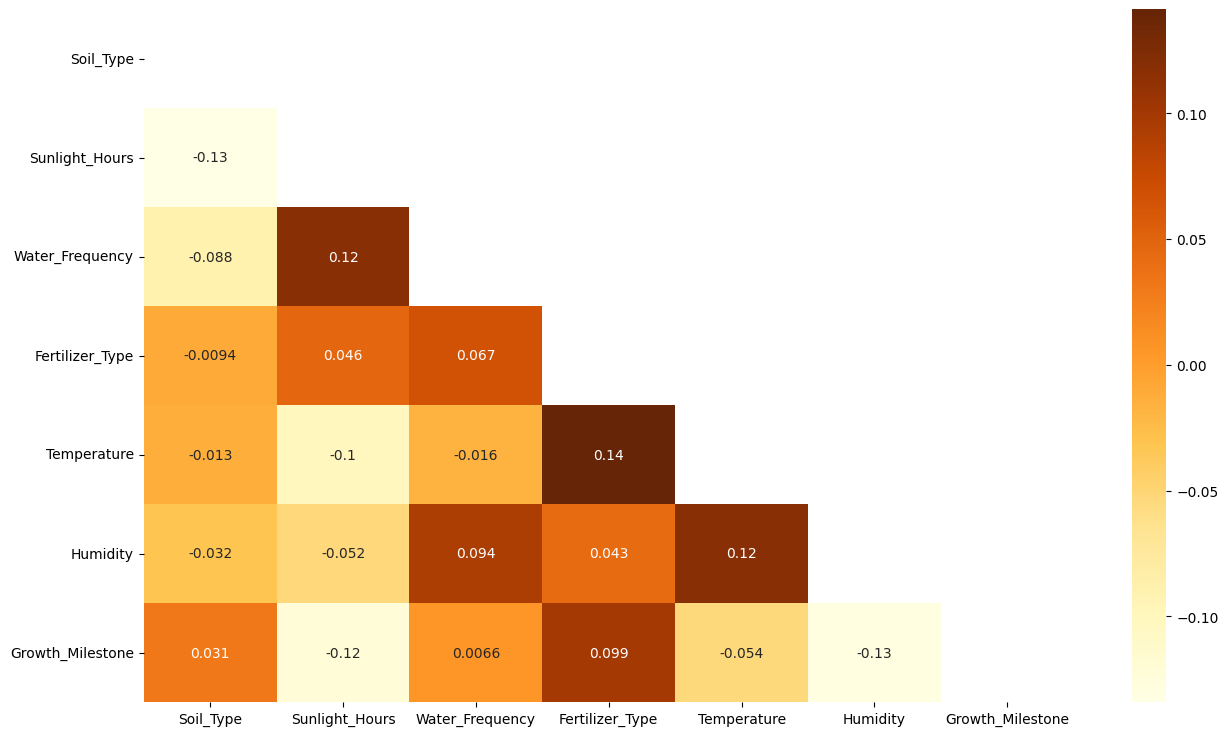

In [6]:
encoder = LabelEncoder()
plant_df['Soil_Type'] = encoder.fit_transform(plant_df['Soil_Type'])
plant_df['Water_Frequency'] = encoder.fit_transform(plant_df['Water_Frequency'])
plant_df['Fertilizer_Type'] = encoder.fit_transform(plant_df['Fertilizer_Type'])
corr = plant_df.corr()
mask = np.triu(np.ones_like(corr))
plt.figure(figsize = (15,9))
sns.heatmap(corr,annot = True, cmap="YlOrBr", mask=mask)
plt.show()

There is no correlation between any of the features in the table.

# 4. Modelling

Let's try and predict growth milestone depending on encoded parameters.

In [7]:
X_train, X_val, y_train, y_val = train_test_split(plant_df.drop(target_col, axis=1), plant_df[target_col],
                                                  test_size=.25, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((144, 6), (49, 6), (144,), (49,))

In [8]:
models = [
    ("cb", CatBoostClassifier(verbose=0)),
    ("rf", RandomForestClassifier()),
    ("xgb", XGBClassifier(verbosity=0)),
         ]

In [9]:
ens_model = VotingClassifier(models, flatten_transform=False, voting="soft")
ens_model.fit(X_train, y_train)

VotingClassifier(estimators=[('cb',
                              <catboost.core.CatBoostClassifier object at 0x7ea60458ae60>),
                             ('rf', RandomForestClassifier()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_type...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                 flatten_transform=False, voting='soft')

In [10]:
y_val_pred = ens_model.predict(X_val)

acc = accuracy_score(y_val, y_val_pred)
acc_report = classification_report(y_val, y_val_pred)
print(acc_report)

              precision    recall  f1-score   support

           0       0.64      0.61      0.62        23
           1       0.67      0.69      0.68        26

    accuracy                           0.65        49
   macro avg       0.65      0.65      0.65        49
weighted avg       0.65      0.65      0.65        49

